In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns #wrapper over matplotlib
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [ ]:
dataset_cols = ["bike_count","hour","temp","humidity","wind", "visibility","dew_pt_temp","radiation","rain","snow","functional"]
data_frame = pd.read_csv("SeoulBikeData.csv").drop({"Date","Holiday","Seasons"},axis=1)
data_frame.columns = dataset_cols

data_frame["functional"] = (data_frame["functional"]=="Yes").astype(int)
data_frame = data_frame[data_frame["hour"]==12]
data_frame = data_frame.drop(["hour"],axis=1)
data_frame.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


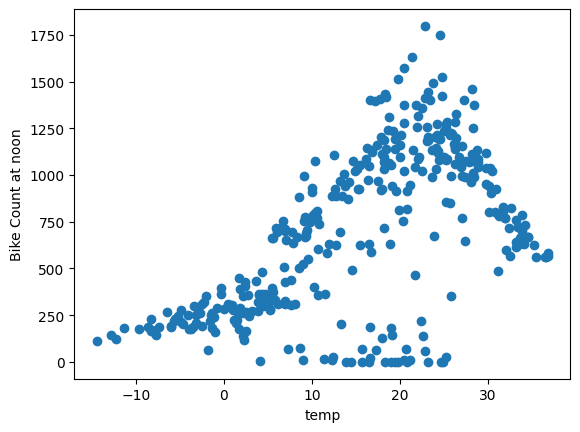

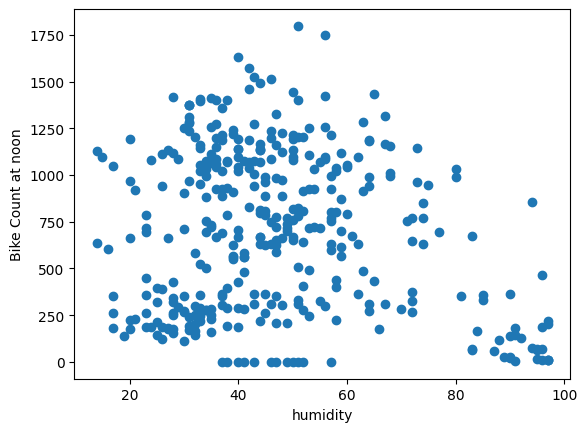

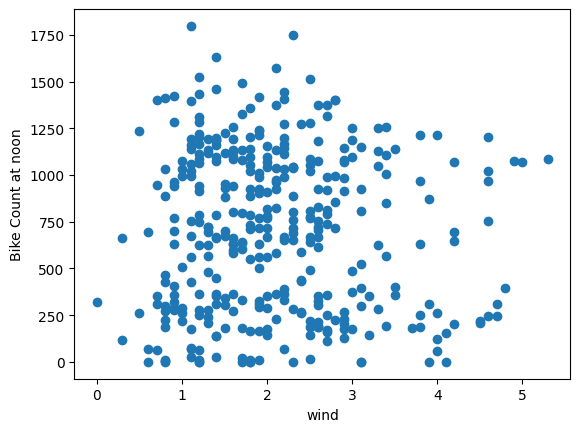

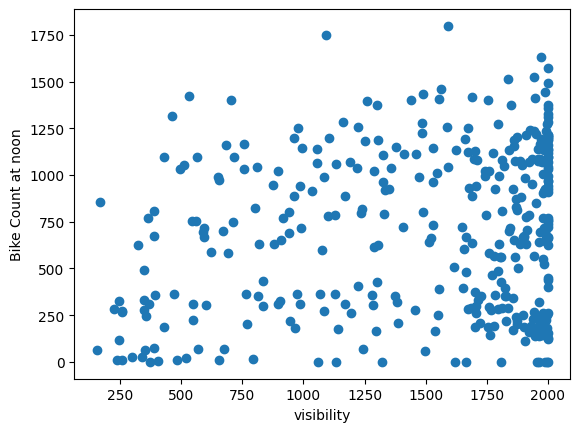

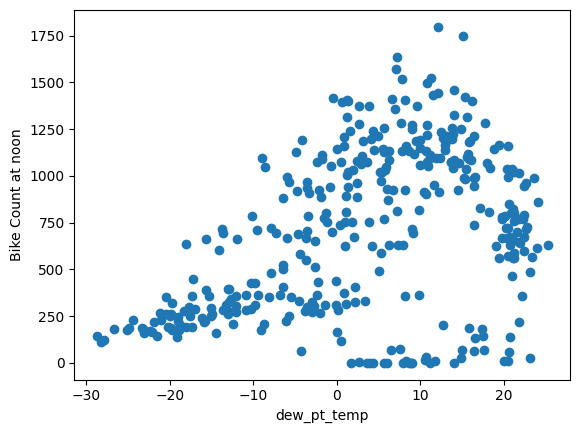

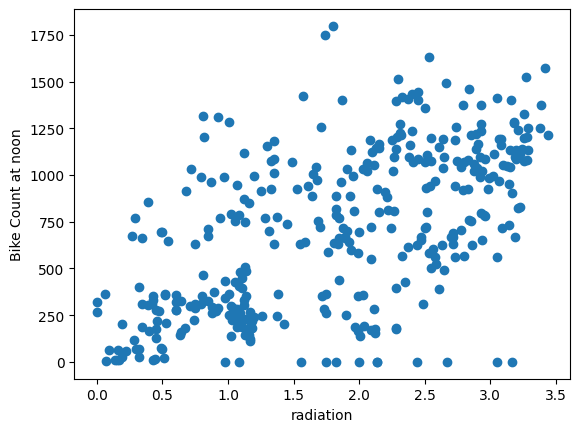

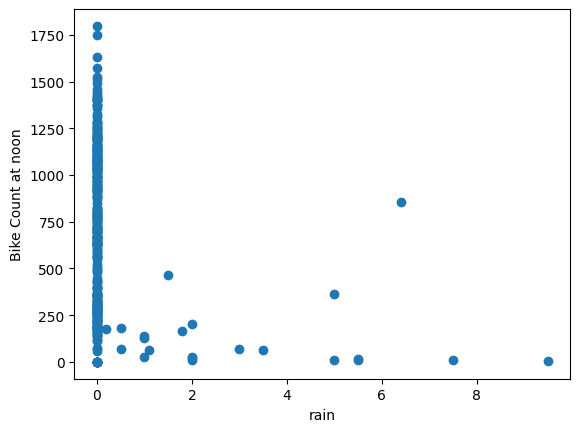

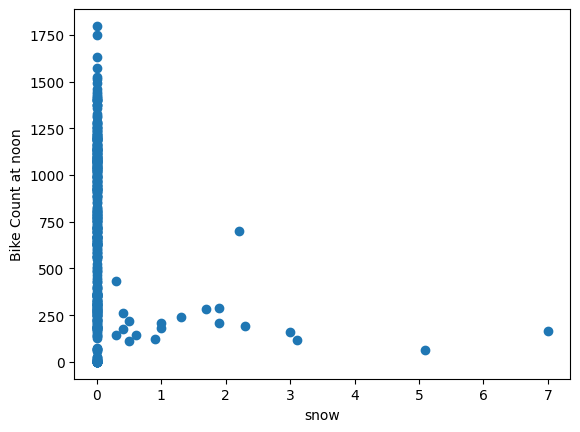

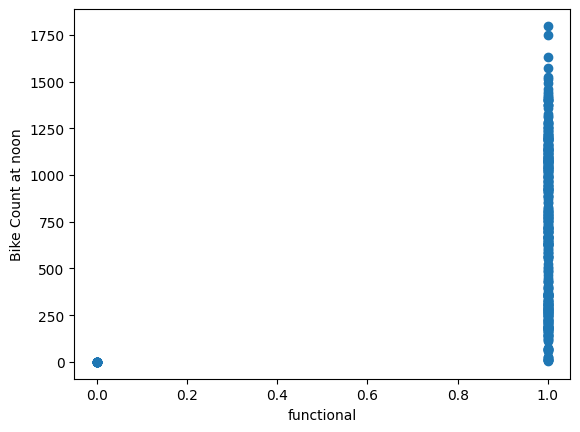

In [ ]:
for label in data_frame.columns[1:]:
  plt.scatter(data_frame[label],data_frame["bike_count"])
  plt.ylabel("Bike Count at noon")
  plt.xlabel(label)

  plt.show()

Note bike count is not linear with respect to some features here. Here, neural nets may be used.

In [ ]:
data_frame = data_frame.drop(["wind","visibility","functional"],axis=1)

In [ ]:
data_frame.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Split to train, valid and testing dataset

In [ ]:
train,validate,test = np.split(data_frame.sample(frac=1),[int(0.6*len(data_frame)), int(0.8*len(data_frame))])

In [ ]:
def get_xy(df,y_label,x_labels=None):
  df = copy.deepcopy(df) #create deepcopy.
  if x_labels is None: # if x_labels is none
    X =df[[c for c in df.columns if c!=y_label]].values #take all columns and get the values
  else:
    if len(x_labels) ==1: #if there is just length of 1
      X = df[x_labels[0]].values.reshape(-1,1) #find that one label's value and make it to 2-D.
    else:
      X = df[x_labels].values
  Y = df[y_label].values.reshape(-1,1) #reshaped to 2D
  data = np.hstack((X,Y)) #horizontally stacking.

  return data, X,Y

In [ ]:
_,X_train_temp,Y_train_temp = get_xy(train,"bike_count", x_labels=["temp"])
_,X_validate_temp,Y_validate_temp = get_xy(validate,"bike_count", x_labels=["temp"])
_,X_test_temp,Y_test_temp = get_xy(test,"bike_count", x_labels=["temp"])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp,Y_train_temp)

LinearRegression()

In [ ]:
temp_reg.score(X_test_temp,Y_test_temp)

0.4374830986242009

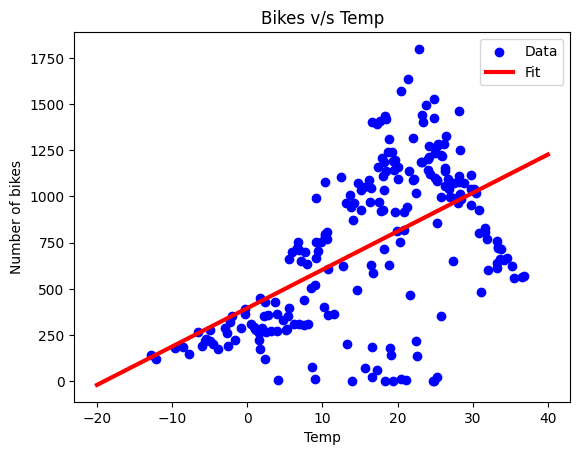

In [ ]:
plt.scatter(X_train_temp,Y_train_temp, label="Data",color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes v/s Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# MULTIPLE REGRESSION

In [ ]:
train,validate,test = np.split(data_frame.sample(frac=1),[int(0.6*len(data_frame)), int(0.8*len(data_frame))])

In [ ]:
_,X_train_all,Y_train_all = get_xy(train,"bike_count", x_labels=data_frame.columns[1:])
_,X_validate_all,Y_validate_all = get_xy(validate,"bike_count", x_labels=data_frame.columns[1:])
_,X_test_all,Y_test_all = get_xy(test,"bike_count", x_labels=data_frame.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, Y_train_all)

LinearRegression()

In [ ]:
all_reg.score(X_test_all,Y_test_all)

0.3538725164556549

# Regression with Neural Network

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None) #This normalizes the model and takes only the temperature
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [ ]:
temp_nn_model = tf.keras.Sequential(
    [
      temp_normalizer,
      tf.keras.layers.Dense(1)
    ]
)

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), Y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_validate_temp,Y_validate_temp)
)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

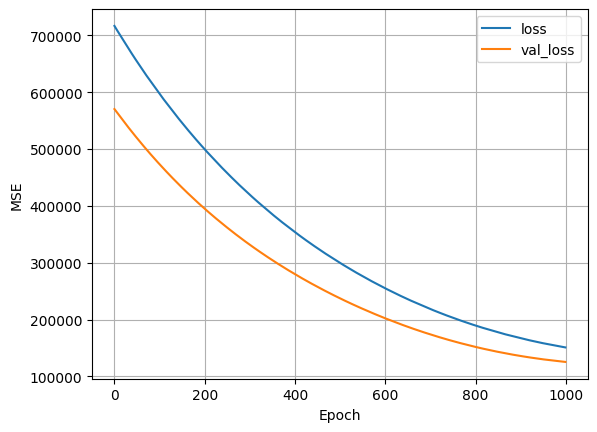

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


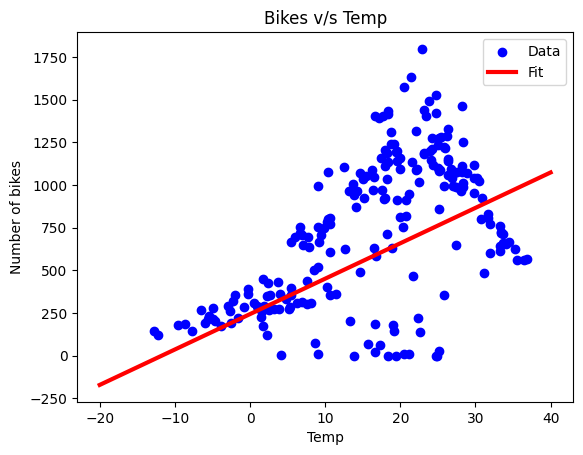

In [ ]:
plt.scatter(X_train_temp,Y_train_temp, label="Data",color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes v/s Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,),axis=-1) #This normalizes the model and takes only the temperature. THe input vectors are just a 1-D array of length 6.
all_normalizer.adapt(X_train_all)

In [ ]:
nn_model = tf.keras.Sequential(
    [
      all_normalizer,
      tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(1)
    ]
)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train_all, Y_train_all,
    verbose=0,
    epochs=100,
    validation_data=(X_validate_all,Y_validate_all)
)

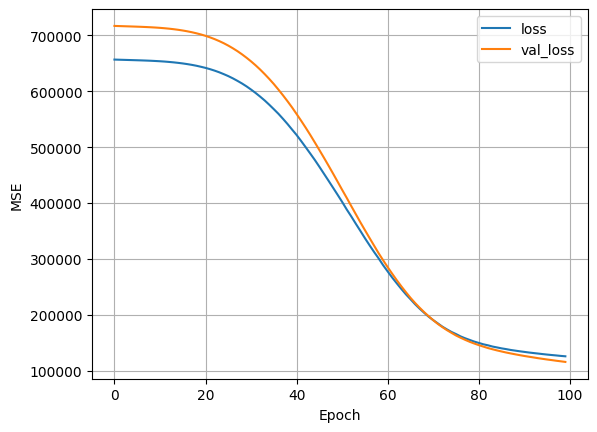

In [ ]:
plot_loss(history)

In [ ]:
#calculate MSE FOR BOTH LINEAR reg and neural net

y_pred_linear = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 4ms/step


In [ ]:
def MSE(y_pred,y_real):
  return (np.square(y_pred - y_real)).mean()

In [ ]:
MSE(y_pred_linear,Y_test_all)

126071.46510647627

In [ ]:
MSE(y_pred_nn,Y_test_all)

157487.5968174731

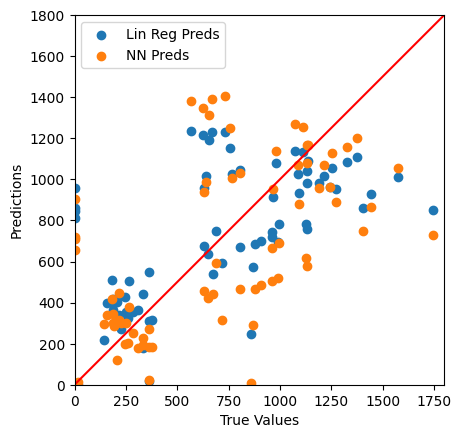

In [ ]:
ax = plt.axes(aspect="equal")
plt.scatter(Y_test_all,y_pred_linear,label="Lin Reg Preds")
plt.scatter(Y_test_all,y_pred_nn,label="NN Preds")


plt.xlabel("True Values")
plt.ylabel("Predictions")
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_= plt.plot(lims,lims,c="red")